
# $K^* \mu \mu$ angular analysis - Getting started

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit

## Reading the data (splitting into bins!)
Taken from Voltron V4

In [19]:
df = pd.read_pickle("data/sig.pkl")

# %% bin splitting
# I'm sure there's a more elegant solution but I can't think of one right now.

bin0 = df[(df['q2'] > 0.1) & (df['q2'] <= 0.98)]
bin1 = df[(df['q2'] > 1.1) & (df['q2'] <= 2.5)]
bin2 = df[(df['q2'] > 2.5) & (df['q2'] <= 4.0)]
bin3 = df[(df['q2'] > 4.0) & (df['q2'] <= 6.0)]
bin4 = df[(df['q2'] > 6.0) & (df['q2'] <= 8.0)]
bin5 = df[(df['q2'] > 15.0) & (df['q2'] <= 17.0)]
bin6 = df[(df['q2'] > 17.0) & (df['q2'] <= 19.0)]
bin7 = df[(df['q2'] > 11.0) & (df['q2'] <= 12.5)]
bin8 = df[(df['q2'] > 1.0) & (df['q2'] <= 6.0)] # ???
# we're only given toy data up to bin 6, so how can we check that this isn't a mistake?
bin9 = df[(df['q2'] > 15.0) & (df['q2'] <= 17.9)]

bins = [bin0, bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

bins[0].head()

,mu_plus_MC15TuneV1_ProbNNk,mu_plus_MC15TuneV1_ProbNNpi,mu_plus_MC15TuneV1_ProbNNmu,mu_plus_MC15TuneV1_ProbNNe,mu_plus_MC15TuneV1_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,mu_plus_PHI,mu_plus_PE,...,Kstar_FDCHI2_OWNPV,J_psi_MM,J_psi_ENDVERTEX_CHI2,J_psi_ENDVERTEX_NDOF,J_psi_FDCHI2_OWNPV,q2,phi,costhetal,costhetak,evtType
10,0.013673,0.002983,0.966088,5.676895e-03,0.001963,6594.92,574.851413,3.131186,2.755104,6595.766331,...,169.407770,808.169625,0.199321,1,52.422005,0.653101,0.654541,-0.658432,-0.995154,0
52,0.000258,0.095961,0.980204,9.708659e-06,0.000006,22545.31,2573.583407,2.860101,-1.430011,22545.557582,...,180.550317,575.416080,1.868878,1,6528.656673,0.331089,0.251222,0.494380,0.925470,0
59,0.000080,0.005632,0.999121,4.725882e-06,0.000002,17165.68,3269.345113,2.342275,1.872554,17166.005172,...,80.421850,408.238691,0.330570,1,356.490454,0.166661,-2.068852,0.181437,-0.314310,0
69,0.000081,0.021237,0.999200,1.928787e-07,0.000004,17936.37,2704.717584,2.579246,0.508966,17936.681200,...,125.208357,359.743951,8.557813,1,71.846260,0.129429,-0.842600,-0.148659,0.320271,0
72,0.012215,0.304623,0.969430,4.447471e-06,0.002332,6093.38,958.479961,2.536513,1.915881,6094.295982,...,41.231172,561.164033,1.047797,1,234.371538,0.314905,-1.506163,-0.546564,-0.717638,0


Let us have a look at the distribution of the variable $cos(\theta_l)$, which will be used below, in one of the bins.

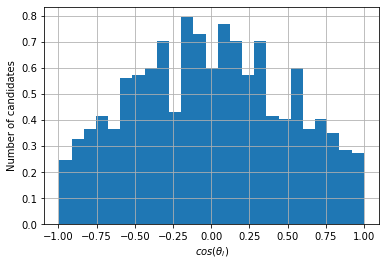

In [20]:
plt.hist(bins[3]['costhetal'], bins=25, density=True)
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

## Fitting
Let us assume a flat acceptance distribution for the following.
We have
$\frac{d^2\Gamma_P}{dq^2dcos\theta_l} = \frac{3}{8}[\frac{3}{2} - \frac{1}{2}F_L + \frac{1}{2}cos2\theta_l(1-3F_L) + \frac{8}{3}A_{FB}cos\theta_l]$

In [21]:
def d2gamma_p_d2q2_dcostheta(fl, afb, cos_theta_l):
    """
    Returns the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param cos_theta_l: cos(theta_l)
    :return:
    """
    ctl = cos_theta_l
    c2tl = 2 * ctl ** 2 - 1
    acceptance = 0.5  # acceptance "function"
    scalar_array = 3/8 * (3/2 - 1/2 * fl + 1/2 * c2tl * (1 - 3 * fl) + 8/3 * afb * ctl) * acceptance
    normalised_scalar_array = scalar_array * 2  # normalising scalar array to account for the non-unity acceptance function
    return normalised_scalar_array

def log_likelihood(fl, afb, _bin):
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    _bin = bins[int(_bin)]
    ctl = _bin['costhetal']
    normalised_scalar_array = d2gamma_p_d2q2_dcostheta(fl=fl, afb=afb, cos_theta_l=ctl)
    return - np.sum(np.log(normalised_scalar_array))

Let us check how the negative log-likelihood function defined above looks like for a given bin and a fixed $A_{FB}$ or a fixed $F_L$.

/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


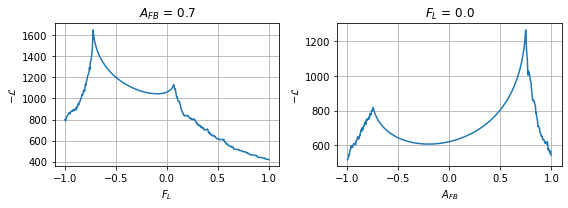

In [22]:
_test_bin = 1
_test_afb = 0.7
_test_fl = 0.0

x = np.linspace(-1, 1, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(x, [log_likelihood(fl=i, afb=_test_afb, _bin=_test_bin) for i in x])
ax1.set_title(r'$A_{FB}$ = ' + str(_test_afb))
ax1.set_xlabel(r'$F_L$')
ax1.set_ylabel(r'$-\mathcal{L}$')
ax1.grid()
ax2.plot(x, [log_likelihood(fl=_test_fl, afb=i, _bin=_test_bin) for i in x])
ax2.set_title(r'$F_{L}$ = ' + str(_test_fl))
ax2.set_xlabel(r'$A_{FB}$')
ax2.set_ylabel(r'$-\mathcal{L}$')
ax2.grid()
plt.tight_layout()
plt.show()

### Fitting
We then use `iminuit` to optimize $A_{FB}$ and $F_L$.

In [23]:
bin_number_to_check = 0  # bin that we want to check in more details in the next cell
bin_results_to_check = None

log_likelihood.errordef = Minuit.LIKELIHOOD
decimal_places = 3
starting_point = [-0.1,0.0]
fls, fl_errs = [], []
afbs, afb_errs = [], []
for i in range(len(bins)):
    m = Minuit(log_likelihood, fl=starting_point[0], afb=starting_point[1], _bin=i)
    m.fixed['_bin'] = True  # fixing the bin number as we don't want to optimize it
    m.limits=((-1.0, 1.0), (-1.0, 1.0), None)
    m.migrad()
    m.hesse()
    if i == bin_number_to_check:
        bin_results_to_check = m
    fls.append(m.values[0])
    afbs.append(m.values[1])
    fl_errs.append(m.errors[0])
    afb_errs.append(m.errors[1])
    print(f"Bin {i}: {np.round(fls[i], decimal_places)} pm {np.round(fl_errs[i], decimal_places)},", f"{np.round(afbs[i], decimal_places)} pm {np.round(afb_errs[i], decimal_places)}. Function minimum considered valid: {m.fmin.is_valid}")

Bin 0: 0.669 pm 0.034, -0.052 pm 0.018. Function minimum considered valid: True


/home/srayan/miniconda3/envs/yr2-comp/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Bin 1: 1.0 pm 0.012, -0.39 pm 0.013. Function minimum considered valid: False
Bin 2: 0.747 pm 0.047, -0.146 pm 0.028. Function minimum considered valid: True
Bin 3: 0.74 pm 0.038, -0.006 pm 0.023. Function minimum considered valid: True
Bin 4: 0.531 pm 0.039, 0.204 pm 0.023. Function minimum considered valid: True
Bin 5: 0.264 pm 0.041, 0.427 pm 0.023. Function minimum considered valid: True
Bin 6: 0.242 pm 0.058, 0.393 pm 0.035. Function minimum considered valid: True
Bin 7: 1.0 pm 0.011, 0.99 pm 0.021. Function minimum considered valid: True
Bin 8: 0.759 pm 0.023, -0.09 pm 0.014. Function minimum considered valid: True
Bin 9: 0.266 pm 0.036, 0.428 pm 0.02. Function minimum considered valid: True


Let us also look at the profiles for $A_{FB}$ and $F_L$ for a bin (e.g. bin number 0).

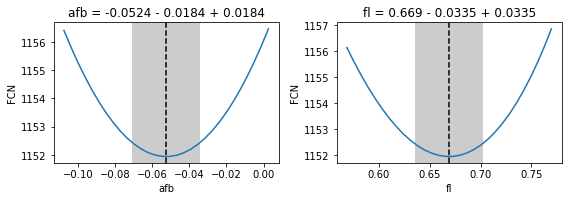

In [24]:
plt.figure(figsize=(8, 5))
plt.subplot(221)
bin_results_to_check.draw_mnprofile('afb', bound=3)
plt.subplot(222)
bin_results_to_check.draw_mnprofile('fl', bound=3)
plt.tight_layout()
plt.show()

We can also plot the resulting fitted PDF over the measured $cos(\theta_l)$ distribution.

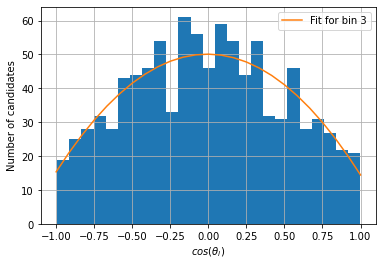

In [25]:
bin_to_plot = 3
number_of_bins_in_hist = 25
cos_theta_l_bin = bins[bin_to_plot]['costhetal']
hist, _bins, _ = plt.hist(cos_theta_l_bin, bins=number_of_bins_in_hist)
x = np.linspace(-1, 1, number_of_bins_in_hist)
pdf_multiplier = np.sum(hist) * (np.max(cos_theta_l_bin) - np.min(cos_theta_l_bin)) / number_of_bins_in_hist
y = d2gamma_p_d2q2_dcostheta(fl=fls[bin_to_plot], afb=afbs[bin_to_plot], cos_theta_l=x) * pdf_multiplier
plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

Finally, let us visualize the results in each bin.

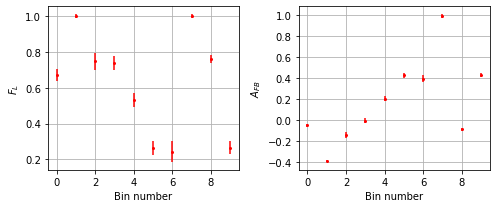

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), afbs, yerr=afb_errs, fmt='o', markersize=2, label=r'$A_{FB}$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$F_L$')
ax2.set_ylabel(r'$A_{FB}$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()
